<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Hard_ex_cstm_arch1_5l_3f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy
## Seeding 
seed = 2
random.seed = seed
#np.random.seed = seed
tf.seed = seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [ ]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    up=keras.layers.UpSampling2D((2,2))

    f_bn= up(up(up(up(bn))))
    f_u1=up(up(up(u1)))
    f_u2=up(up(u2))
    f_u3=up(u3)
    deep_supervised = keras.layers.Concatenate()([f_bn,f_u1,f_u2,f_u3,u4])
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(deep_supervised)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [ ]:
"""tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=24
)"""

'tf.keras.utils.plot_model(\n    model,\n    to_file="model.png",\n    show_shapes=True,\n    \n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=24\n)'

In [ ]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [ ]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))

54


In [ ]:

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [ ]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))   

In [ ]:
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


## train data

In [ ]:
train_batch = np.zeros(shape = (len(train_data)*5, 512, 512, 3));
train_label = np.zeros(shape = (len(train_data)*5, 512, 512, 1));
rot=[-4,-3,-2,-1,1,2,3,4]

for file_index in range(0,len(train_data)*5,5):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = resize(imread(train_data[int(file_index/5)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(train_data_gt[2][int(file_index/5)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label  = train_label / np.max(train_label)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(270, 512, 512, 3)
(270, 512, 512, 1)


## test data

In [ ]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(test_data_gt[2][int(file_index)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

test_batch  = test_batch/255

test_label  = test_label / np.max(test_label)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [ ]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [ ]:
# seed = 2
# random.seed = seed
# np.random.seed = seed
# tf.seed = seed
# tf.random.set_seed(2)
# image_size=512
# opt=keras.optimizers.Adam(learning_rate = 0.002,beta_1=0.8)
# model = UNet_modular(depth=5,f=3)
# model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.MeanIoU(num_classes=2)])   

In [ ]:
# model.summary()

In [ ]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
depths=[2,3,4,5,6]
models=[]
histories=[]
for depth in [5]:
  opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.8)
  model = UNet_modular(depth=depth,f=3)
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=10)
  #rlrop=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3) 
  #gen=data_gen(train_data,train_data_gt[2])
  #hist = model.fit(gen, steps_per_epoch=len(train_data_gt[2]), epochs = 100, verbose = 2, callbacks=[early_stopping], shuffle = True)
  hist = model.fit(x = train_batch, y = train_label, batch_size = 3, epochs = 170, verbose = 1, callbacks=[early_stopping], validation_split = 8/135, shuffle = True)
  models.append(model)
  histories.append(hist)

[3, 6, 12, 24, 48]
Epoch 1/170
85/85 [==============================] - 19s 167ms/step - loss: 0.9660 - mean_io_u_2: 0.4878 - val_loss: 0.9983 - val_mean_io_u_2: 0.4996
Epoch 2/170
85/85 [==============================] - 13s 158ms/step - loss: 0.9040 - mean_io_u_2: 0.4461 - val_loss: 0.9981 - val_mean_io_u_2: 0.2205
Epoch 3/170
85/85 [==============================] - 13s 159ms/step - loss: 0.8161 - mean_io_u_2: 0.4460 - val_loss: 0.9974 - val_mean_io_u_2: 0.2623
Epoch 4/170
85/85 [==============================] - 13s 157ms/step - loss: 0.7796 - mean_io_u_2: 0.4601 - val_loss: 0.9727 - val_mean_io_u_2: 0.2914
Epoch 5/170
85/85 [==============================] - 13s 156ms/step - loss: 0.7811 - mean_io_u_2: 0.4762 - val_loss: 0.9993 - val_mean_io_u_2: 0.4378
Epoch 6/170
85/85 [==============================] - 13s 156ms/step - loss: 0.7314 - mean_io_u_2: 0.4960 - val_loss: 0.9944 - val_mean_io_u_2: 0.4996
Epoch 7/170
85/85 [==============================] - 13s 156ms/step - loss: 0.605

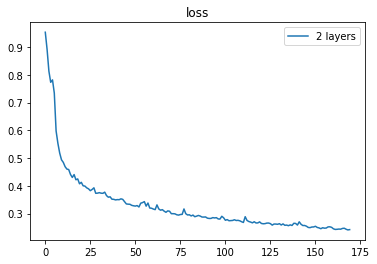

In [ ]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(i+2))
plt.legend()
plt.title('loss')
plt.show()
# for i,hist in enumerate(histories):
#   plt.plot(hist.history['mean_io_u_{}'.format(str(1+i))],label="{} layers".format(i+2))
# plt.legend()
# plt.title('mean_io_u score')
# plt.show()

## prediction


In [ ]:
predicted_test_label=np.zeros(test_label.shape)
for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
  predicted_test_label[i]=models[0].predict(np.expand_dims(test_batch[i],axis=0)) 

(512, 512, 1)


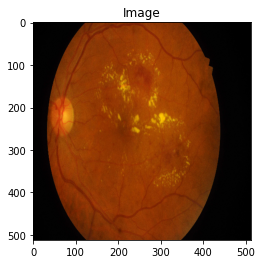

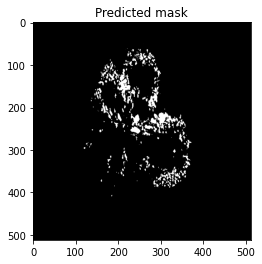

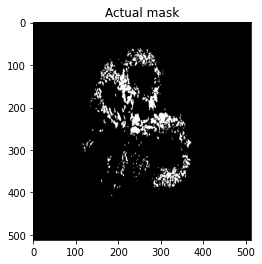

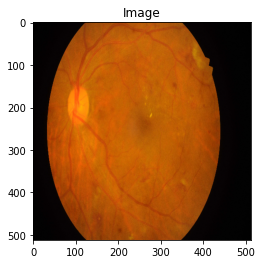

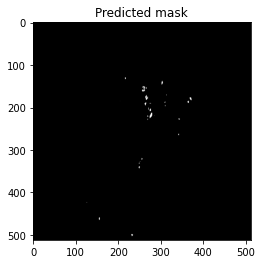

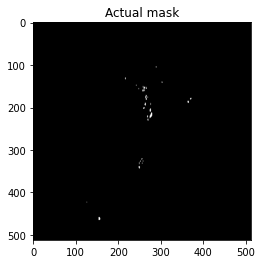

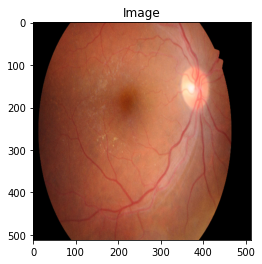

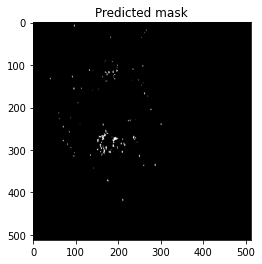

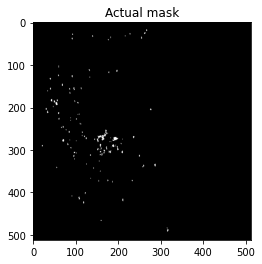

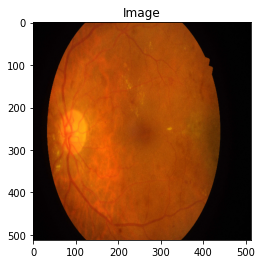

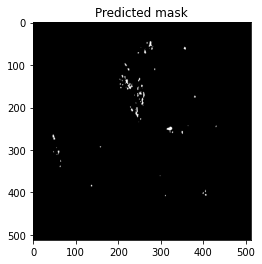

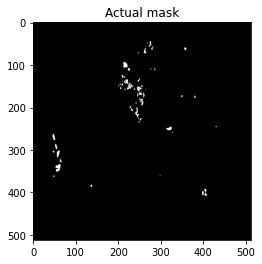

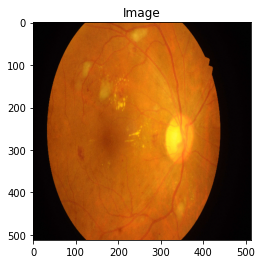

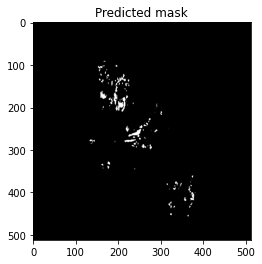

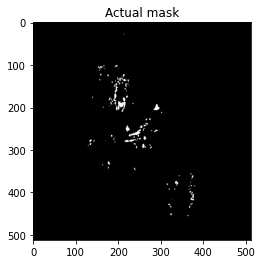

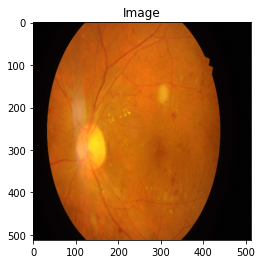

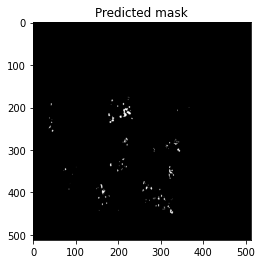

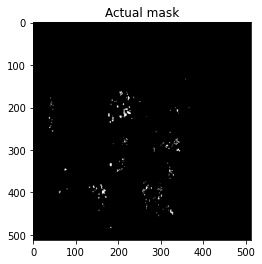

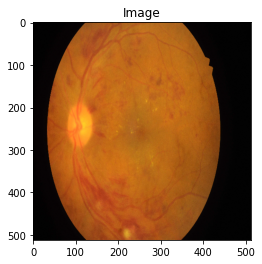

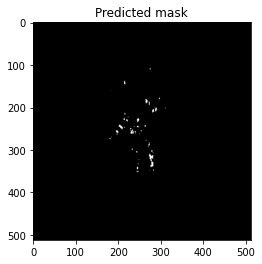

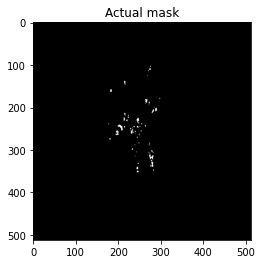

In [ ]:
# predicted_test_label=models[0].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(7):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

2 layers
train  0  test  0.9617151742534485
Train  F1 score: 0.000000 Test F1 score: 0.755337
train AUPR 0  test AUPR 0.781714587908287


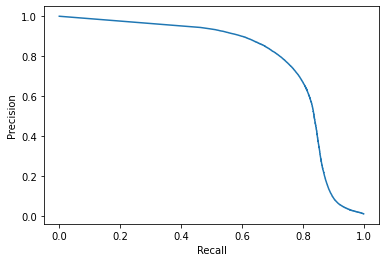

In [ ]:
for i,model in enumerate(models):
  print(i+2, "layers")
  #generate the masks
 
#   predicted_test_label=model.predict(test_batch)
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test ",test_auc)

  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  #AUPR

  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
  #train_auc=auc(train_aupr[1],train_aupr[0] )
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  del predicted_test_label 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/IDRid/model_EX.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/IDRid/model_EX.h5")
print("Saved model to disk")

Saved model to disk


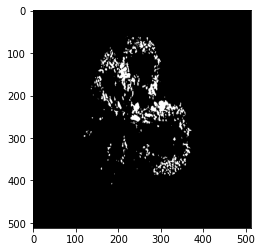

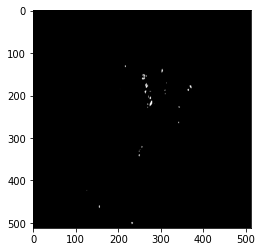

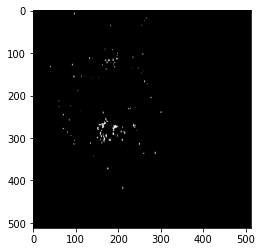

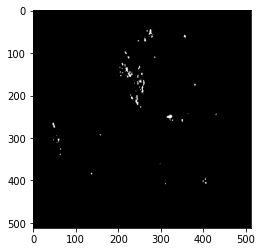

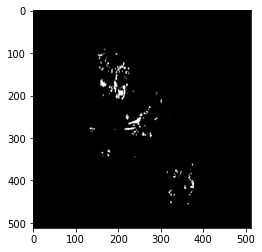

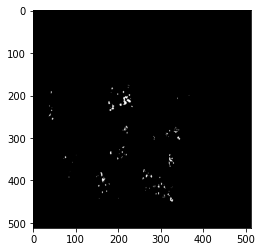

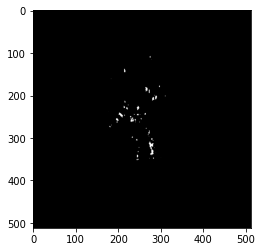

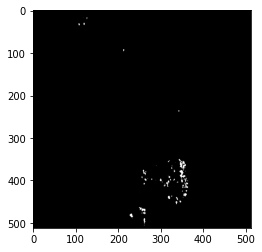

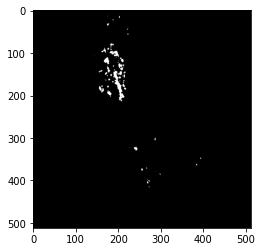

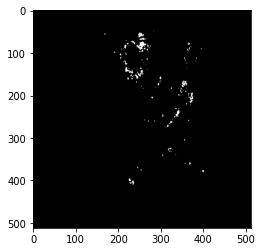

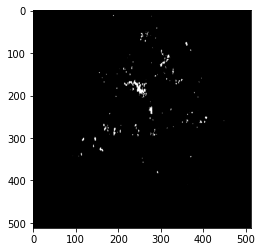

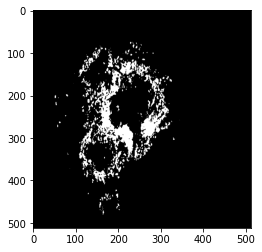

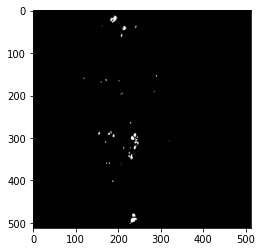

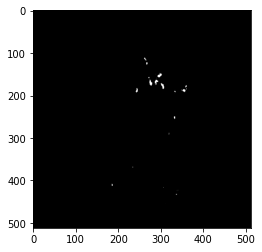

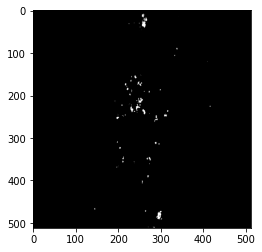

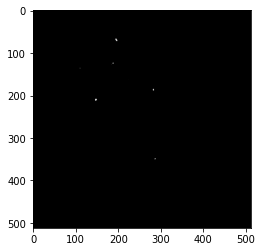

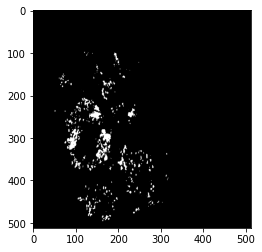

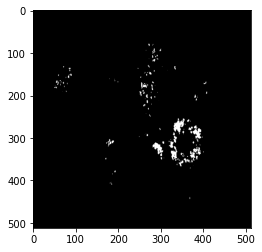

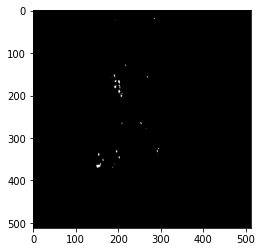

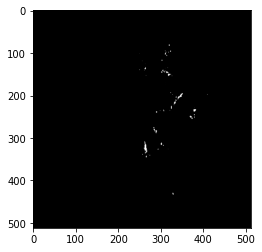

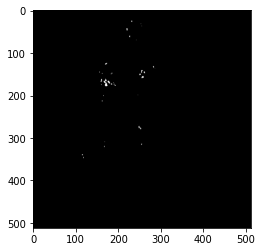

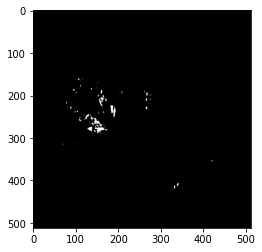

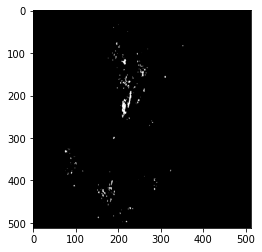

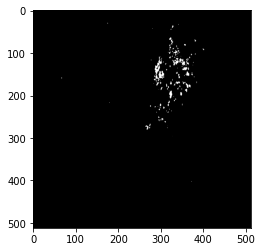

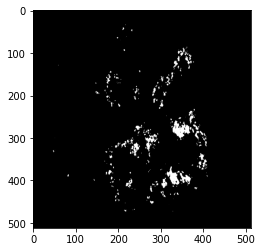

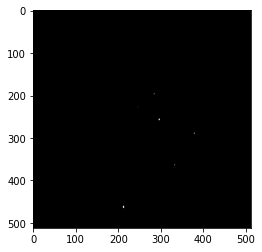

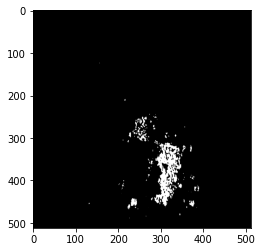

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(27):
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.show()
    name = "hard_ex_pred_mask" + str(i)
    plt.savefig(("/content/drive/MyDrive/IDRid/" + name + ".png"))
